# attentive.py

In [1]:
!pip install torch_geometric rdkit pubchempy
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATv2Conv, GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax

import os.path as osp
from math import sqrt

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from tqdm import trange
import sys

import matplotlib.pyplot as plt
import numpy as np


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


# {'num_layers': 2, 'T': 3, 'hidden': 250, 'dropout': 0.4711121090885816, 'wd': 0.0001, 'lr': 0.005382822500641914}
class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATv2Conv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATv2Conv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.silu(self.lin1(x))

        h = F.silu(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = F.silu(self.gru(h, x))

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            #print(f"Before: {h.shape}")
            h = conv(x, edge_index) + x
            #print(f"after: {h.shape}")
            h = F.silu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = F.silu(gru(h, x))

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.silu(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = F.silu(self.mol_gru(h, out))

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


Defaulting to user installation because normal site-packages is not writeable


# attentive_fp.py

In [2]:
!pip install rdkit
!pip install optuna
import optuna
from optuna.trial import TrialState
import os.path as osp
from math import sqrt

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
#from attentive_fp import AttentiveFP


class GenFeatures:
    def __init__(self):
        self.symbols = [
            'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
            'Te', 'I', 'At', 'other'
        ]

        self.hybridizations = [
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            'other',
        ]

        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, data):
        # Generate AttentiveFP features according to Table 1.
        mol = Chem.MolFromSmiles(data.smiles)

        xs = []
        from rdkit.Chem import Descriptors

    def __call__(self, data):
        # Generate AttentiveFP features according to Table 1.
        mol = Chem.MolFromSmiles(data.smiles)

        xs = []
        for atom in mol.GetAtoms():
            symbol = [0.] * len(self.symbols)
            symbol[self.symbols.index(atom.GetSymbol())] = 1.
            degree = [0.] * 6
            degree[atom.GetDegree()] = 1.
            formal_charge = atom.GetFormalCharge()
            radical_electrons = atom.GetNumRadicalElectrons()
            hybridization = [0.] * len(self.hybridizations)
            hybridization[self.hybridizations.index(
                atom.GetHybridization())] = 1.
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            hydrogens[atom.GetTotalNumHs()] = 1.
            chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            is_in_ring = 1. if atom.IsInRing() else 0.
            mass = atom.GetMass()
            is_donor = 1. if rdMolDescriptors.CalcNumHBD(mol) > 0 else 0.
            is_acceptor = 1. if rdMolDescriptors.CalcNumHBA(mol) > 0 else 0.
            if atom.HasProp('_CIPCode'):
                chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.

            # Append extra atom features
            x = torch.cat((x, torch.tensor([is_in_ring, mass, is_donor, is_acceptor])))

            x = torch.tensor(symbol + degree + [formal_charge] +
                             [radical_electrons] + hybridization +
                             [aromaticity] + hydrogens + [chirality] +
                             chirality_type)
            xs.append(x)

        data.x = torch.stack(xs, dim=0)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            bond_dir = 0.
            if bond.GetBondDir() in [BondDir.ENDUPRIGHT, BondDir.ENDDOWNRIGHT]:
                bond_dir = 1.

            if conf is not None:
                idx1, idx2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                pos1 = conf.GetAtomPosition(idx1)
                pos2 = conf.GetAtomPosition(idx2)
                bond_length = float((pos1 - pos2).Length())
            else:
                bond_length = 0.
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor(
                + [bond_length, bond_dir]
                [single, double, triple, aromatic, conjugation, ring] + stereo)

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        return data

def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

<>:113: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:113: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_1761/2891615107.py:113: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  + [bond_length, bond_dir]


In [3]:
import random
import numpy as np
import copy
import os.path as osp
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdchem import BondDir
from rdkit.Chem import AllChem

# Compute molecule-level info once
#mol = Chem.AddHs(mol)
#AllChem.EmbedMolecule(mol, AllChem.ETKDG())
#conf = mol.GetConformer() if mol.GetNumConformers() > 0 else None

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(20)

# Use current working directory in Jupyter
notebook_dir = osp.dirname(osp.abspath(''))
path = osp.abspath('../data/AFP_Mol')

#path = '/content/drive/MyDrive/my_project/data/AFP_Mol'
dataset = MoleculeNet(path, name='ESOL', pre_transform=GenFeatures()).shuffle()

N = len(dataset) // 10
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200)
test_loader = DataLoader(test_dataset, batch_size=200)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AttentiveFP(in_channels=39, hidden_channels=200, out_channels=1,
                    edge_dim=10, num_layers=3, num_timesteps=2,
                    dropout=0.2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
                             weight_decay=10**-5)

for epoch in range(1, 501):
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    if(epoch%10==0):
      print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')


def objective(trial):
    set_seed(21)  # Ensures reproducibility

    # Suggest hyperparameters
    num_layers = trial.suggest_int("num_layers", 2, 5)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # Define model and optimizer with trial parameters
    model = AttentiveFP(
        in_channels=39,
        hidden_channels=200,
        out_channels=1,
        edge_dim=10,
        num_layers=num_layers,
        num_timesteps=2,
        dropout=0.2
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    # Early stopping
    best_val = float("inf")
    best_model_state = None
    patience = 20
    counter = 0

    for epoch in range(1, 201):
        train_rmse = train()
        val_rmse = test(test_loader)

        if val_rmse < best_val:
            best_val = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    # Save best model for this trial
    trial.set_user_attr("best_model_state_dict", best_model_state)

    return best_val

# Run study
#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=25)

# Report best trial
#best_trial = study.best_trial
#print("Best Trial:")
#print(f"  Value: {best_trial.value:.4f}")
#for k, v in best_trial.params.items():
#    print(f"  {k}: {v}")



Epoch: 010, Loss: 1.1102 Val: 1.0276 Test: 1.0525
Epoch: 020, Loss: 0.9039 Val: 0.8713 Test: 0.8221
Epoch: 030, Loss: 0.7570 Val: 0.7925 Test: 0.6918
Epoch: 040, Loss: 0.7213 Val: 0.7801 Test: 0.6373
Epoch: 050, Loss: 0.6278 Val: 0.6809 Test: 0.6139
Epoch: 060, Loss: 0.5950 Val: 0.6420 Test: 0.5699
Epoch: 070, Loss: 0.5527 Val: 0.6054 Test: 0.5688
Epoch: 080, Loss: 0.5187 Val: 0.6165 Test: 0.5219
Epoch: 090, Loss: 0.5027 Val: 0.5990 Test: 0.5351
Epoch: 100, Loss: 0.5318 Val: 0.5350 Test: 0.5275
Epoch: 110, Loss: 0.4315 Val: 0.5874 Test: 0.5186
Epoch: 120, Loss: 0.4144 Val: 0.5697 Test: 0.5143
Epoch: 130, Loss: 0.4291 Val: 0.5890 Test: 0.5056
Epoch: 140, Loss: 0.3904 Val: 0.5814 Test: 0.5035
Epoch: 150, Loss: 0.3750 Val: 0.5149 Test: 0.5637
Epoch: 160, Loss: 0.3796 Val: 0.5476 Test: 0.5270
Epoch: 170, Loss: 0.3522 Val: 0.5520 Test: 0.5208
Epoch: 180, Loss: 0.3450 Val: 0.5067 Test: 0.5164
Epoch: 190, Loss: 0.3142 Val: 0.5651 Test: 0.4991
Epoch: 200, Loss: 0.3369 Val: 0.5507 Test: 0.5106


112


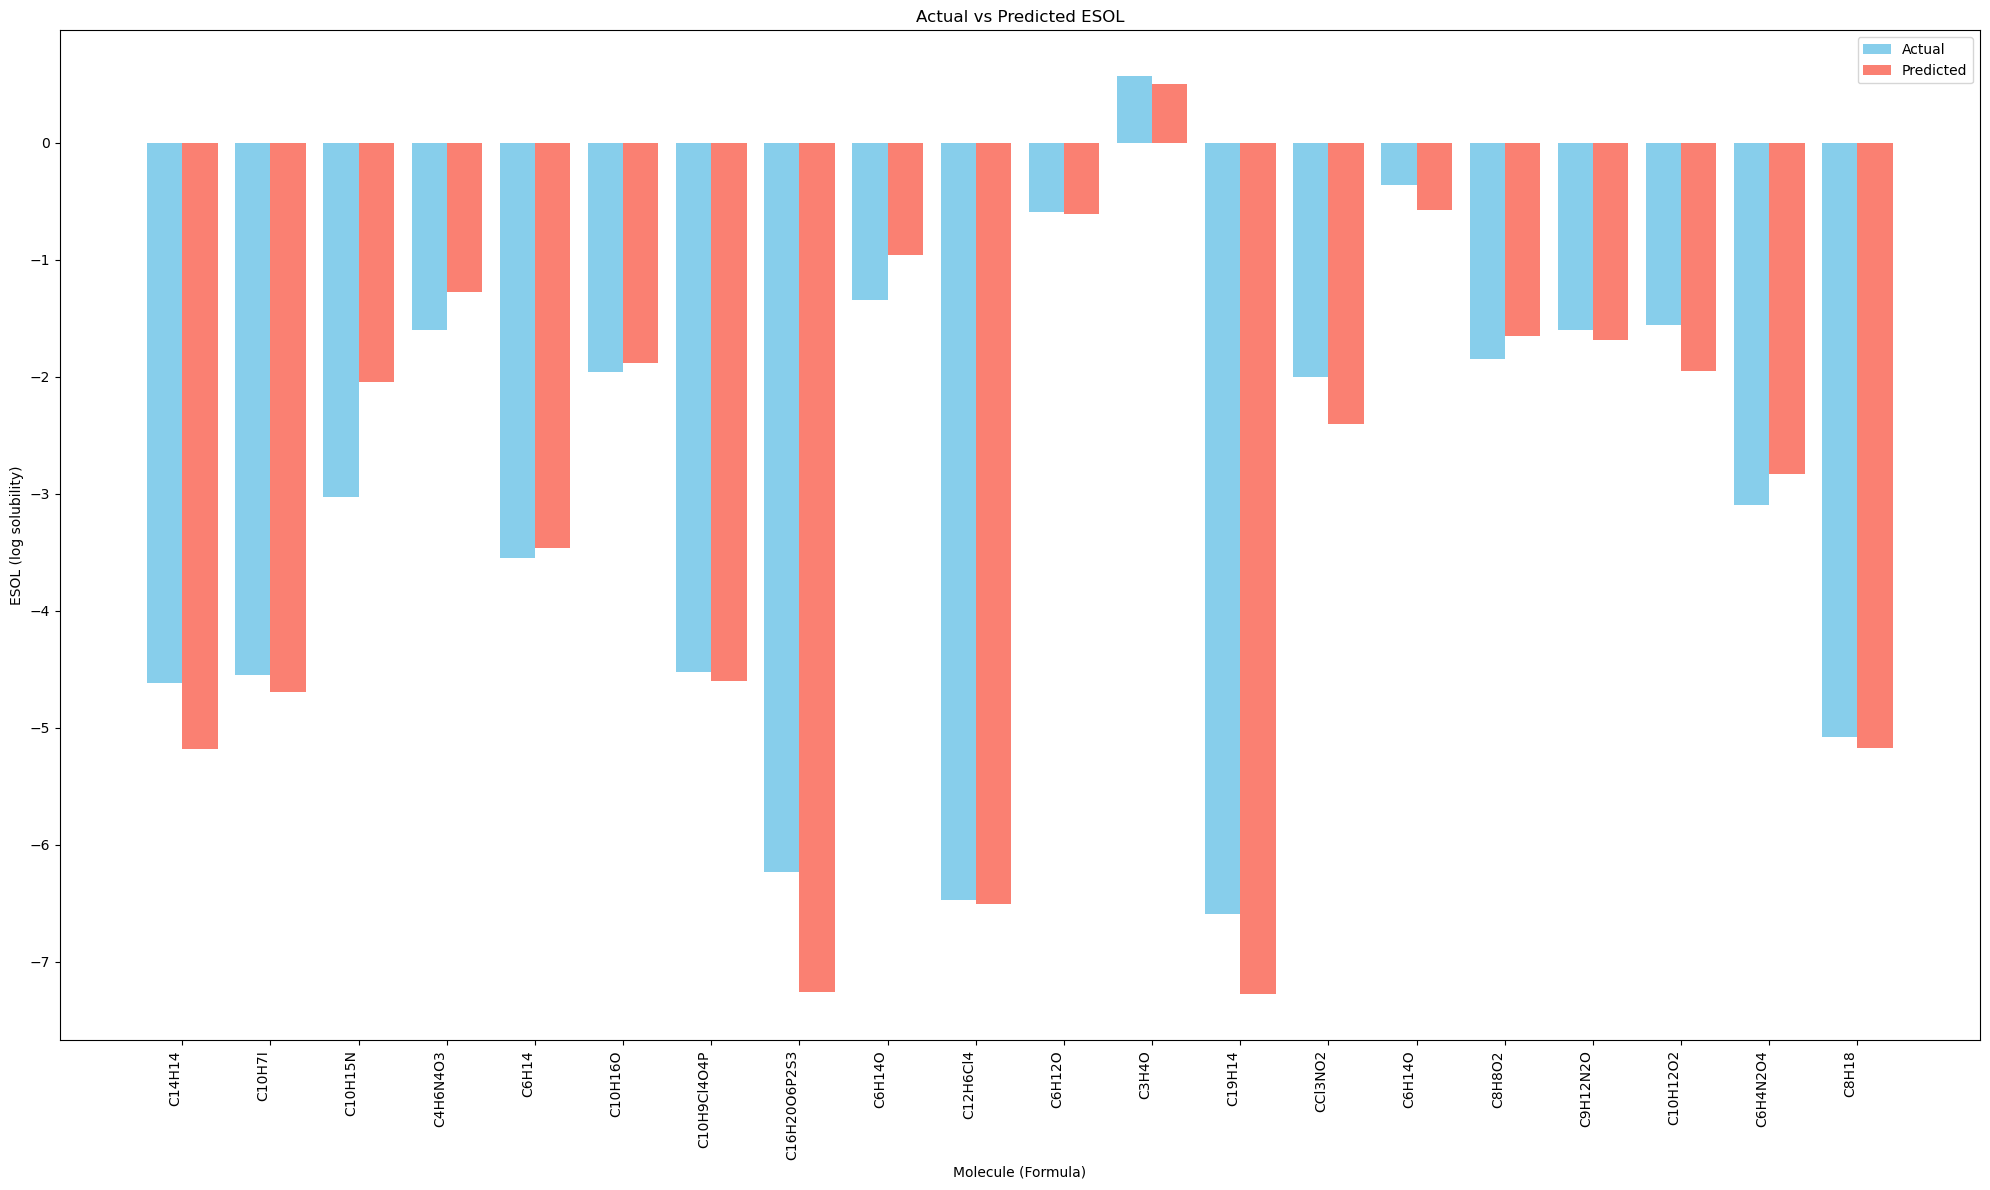

In [5]:
@torch.no_grad()
def predict(loader):
    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        y_true.append(data.y.cpu())
        y_pred.append(out.cpu())
    return torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)



y_true, y_pred = predict(test_loader)


y_true = y_true.squeeze().numpy()
y_pred = y_pred.squeeze().numpy()


smiles_list = [data.smiles for data in test_dataset]


#num_of_data = len(smiles_list)
num_of_data = 20
print(len(smiles_list))

# Convert SMILES to molecular formula
mol_formulas = []
for smiles in smiles_list[:num_of_data]:
    mol = Chem.MolFromSmiles(smiles)
    formula = rdMolDescriptors.CalcMolFormula(mol) if mol else "Unknown"
    mol_formulas.append(formula)


indices = np.arange(num_of_data)
bar_width = 0.4

plt.figure(figsize=(20, 12))
plt.bar(indices - bar_width/2, y_true[:num_of_data], width=bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width/2, y_pred[:num_of_data], width=bar_width, label='Predicted', color='salmon')

# plt.xticks(indices, mol_formulas, rotation=45, ha='right', fontsize=10)
plt.xticks(indices, mol_formulas, rotation=90, ha='right', fontsize=10)
plt.xlabel("Molecule (Formula)")
plt.ylabel("ESOL (log solubility)")
plt.title("Actual vs Predicted ESOL")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pubchempy as pcp

# for formula in mol_formulas:
#     print(formula)

# for smile in smiles_list:
#     print(smile)
mol_names = []
for smiles in smiles_list:
    try:
        mol = Chem.MolFromSmiles(smiles)
        molformula = rdMolDescriptors.CalcMolFormula(mol) if mol else "Unknown"
        if mol:
            # Convert SMILES to PubChem compound
            compounds = pcp.get_compounds(smiles, namespace='smiles')
            if compounds:
                print(f"{smiles} → {compounds[0].iupac_name} (common name: {compounds[0].synonyms[0]})")
                if len(compounds[0].synonyms[0]) > 30:
                    mol_names.append(molformula)
                else:
                    mol_names.append(compounds[0].synonyms[0])
            else:
                print(f"{smiles} → No match found")
                mol_names.append(f"Mol: {molformula}, No pubchempy name found")
        else:
            print(f"{smiles} → Invalid SMILES")
            mol_names.append(f"Smile: {smiles}, invalid")
    except Exception as e:
        print(f"{smiles} → Error: {e}")
        mol_names.append(f"Smile: {smiles}, error")

C(Cc1ccccc1)c2ccccc2 → 2-phenylethylbenzene (common name: 1,2-Diphenylethane)
Ic1cccc2ccccc12 → 1-iodonaphthalene (common name: 1-IODONAPHTHALENE)
CCN(CC)c1ccccc1 → N,N-diethylaniline (common name: N,N-DIETHYLANILINE)
NC(=O)NC1NC(=O)NC1=O  → (2,5-dioxoimidazolidin-4-yl)urea (common name: allantoin)
CCC(C)(C)C → 2,2-dimethylbutane (common name: 2,2-DIMETHYLBUTANE)
CC1(C)C2CCC1(C)C(=O)C2 → 1,7,7-trimethylbicyclo[2.2.1]heptan-2-one (common name: camphor)
COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl → [2-chloro-1-(2,4,5-trichlorophenyl)ethenyl] dimethyl phosphate (common name: Phosphoric acid, 2-chloro-1-(2,4,5-trichlorophenyl)ethenyl dimethyl ester)
COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1 → [4-(4-dimethoxyphosphinothioyloxyphenyl)sulfanylphenoxy]-dimethoxy-sulfanylidene-lambda5-phosphane (common name: temephos)
CCCOC(C)C → 1-propan-2-yloxypropane (common name: Isopropyl propyl ether)
Clc1ccc(Cl)c(c1)c2cccc(Cl)c2Cl  → 1,2-dichloro-3-(2,5-dichlorophenyl)benzene (common name: 2,2',3,5'-TETRAC

In [ ]:
# for moleculename in mol_names:
#     print(moleculename)

In [ ]:
plt.figure(figsize=(20, 12))
plt.bar(indices - bar_width/2, y_true[:num_of_data], width=bar_width, label='Actual', color='skyblue')
plt.bar(indices + bar_width/2, y_pred[:num_of_data], width=bar_width, label='Predicted', color='salmon')

plt.xticks(indices, mol_names[:num_of_data], rotation=90, ha='right', fontsize=15)
plt.xlabel("Molecule", fontsize=20)
plt.ylabel("ESOL (log solubility)", fontsize=20)
plt.title("Actual vs Predicted ESOL", fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()